# Data Visualizing

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

country_map = {'Azerbaijan': 'AZ', 'Korea': 'KR', 'Myanmar': 'MM', 'UK': 'UK', 'US': 'US'}
model_map = {
    "glm4v": "GLM4-v-Plus",
    "internVL": "InternVL2.5-28B",
    "gpt4o": "GPT-4o",
}

## Cultural Identification

In [8]:
def load_cultural_data(csv_file_path):
    df = pd.read_csv(csv_file_path)

    # Prepare the data dictionary to include model-specific data
    data = {}

    # Loop through each row and structure the data
    for _, row in df.iterrows():
        country_race = row["Country-Race"].split("-")
        country = country_race[0]
        race = country_race[1] if len(country_race) > 1 else None

        # if race is written in camel case, separate it with a space
        race = ''.join(' ' + c if c.isupper() else c for c in race).strip()

        if country not in data:
            data[country] = {}

        for col in df.columns[1:]:  # Exclude "Country-Race"
            if pd.notna(row[col]):  # Skip NaN values
                model, category = col.split("-")
                if model not in data[country]:
                    data[country][model] = {}
                if category not in data[country][model]:
                    data[country][model][category] = {}
                data[country][model][category][race] = row[col]
    return data

models = ["gpt4o", "glm4v", "internVL"]
categories = ["Clothes", "Festival", "Food"]
races = ["Original", "East Asian", "African", "South Asian", "Caucasian"]
race_colors = {"Original": "#8c564b", "East Asian": "#2c6e49", "African": "#4c956c", "South Asian": "#ffc9b9", "Caucasian": "#d68c45"}

### Bar Chart

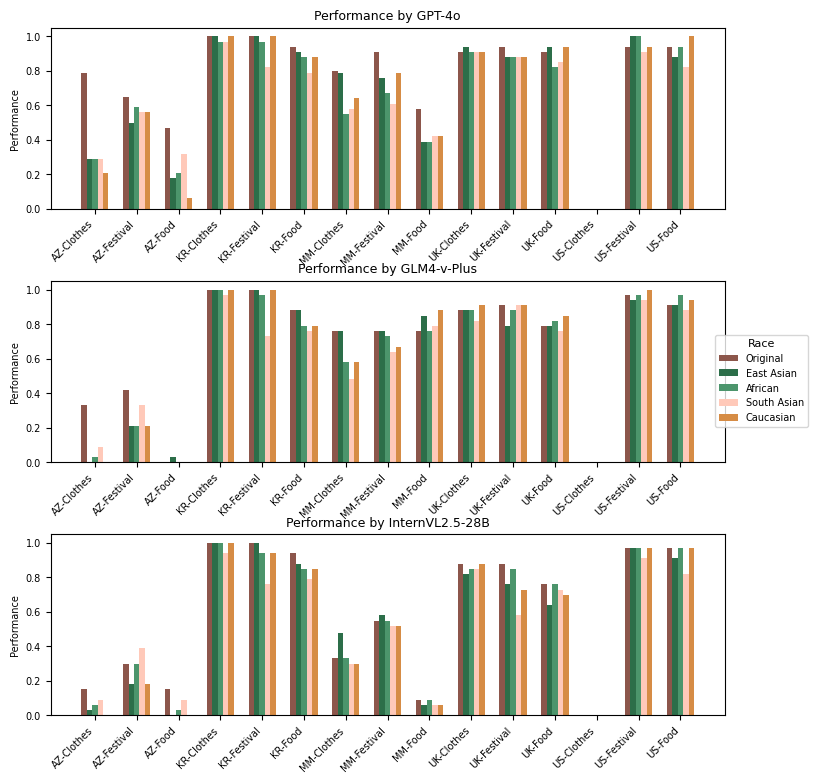

In [9]:
data = load_cultural_data("responses/cultural_accuracy_bar.csv")
# Create one figure with three subplots vertically
fig, axes = plt.subplots(3, 1, figsize=(8, 8))
fig.tight_layout(pad=3.0)  # Add some padding between subplots
label_font_size = 7
# Loop through models and corresponding axes
for ax_idx, (model, ax) in enumerate(zip(models, axes)):
    x = np.arange(len(data) * len(categories))
    width = 0.13

    bar_offsets = []
    for i, race in enumerate(races):
        offsets = width * i
        heights = []
        labels = []

        for country in data.keys():
            for category in categories:
                heights.append(data[country].get(model, {}).get(category, {}).get(race, 0))
                labels.append(f"{country_map[country]}-{category}")

        bar_offsets.append(x + offsets)
        bars = ax.bar(
            x + offsets, 
            heights, 
            width, 
            label=race, 
            color=race_colors.get(race, "#cccccc")
        )

    # Set title for each subplot
    ax.set_title(f"Performance by {model_map[model]}", fontsize=label_font_size+2)
    
    # Only show x-axis labels for the bottom subplot
    ax.set_xticks(x + width * (len(races) - 1) / 2)
    ax.set_xticklabels(labels, rotation=45, ha='right', fontsize=label_font_size)    
    ax.set_ylabel("Performance", fontsize=label_font_size)
    ax.tick_params(axis='y', labelsize=label_font_size)  # Change 8 to your desired font size
# Adjust layout to make more space between subplots
plt.subplots_adjust(hspace=0.4)  # Increase vertical space between subplots

# Create a single legend for the entire figureGet handles and labels from the last subplot
handles, labels = axes[-1].get_legend_handles_labels()
# For legend
fig.legend(handles, labels, title="Race", 
          loc='center', bbox_to_anchor=(0.98, 0.5),
          fontsize=label_font_size,  # For legend labels
          title_fontsize=label_font_size+1)  # For legend title

# Save and show the figure
plt.savefig("Assets/cultural_accuracy_combined.png", 
            bbox_inches='tight',  # Ensure the legend isn't cut off
            dpi=300)             # Higher resolution
plt.show()

### Heatmap

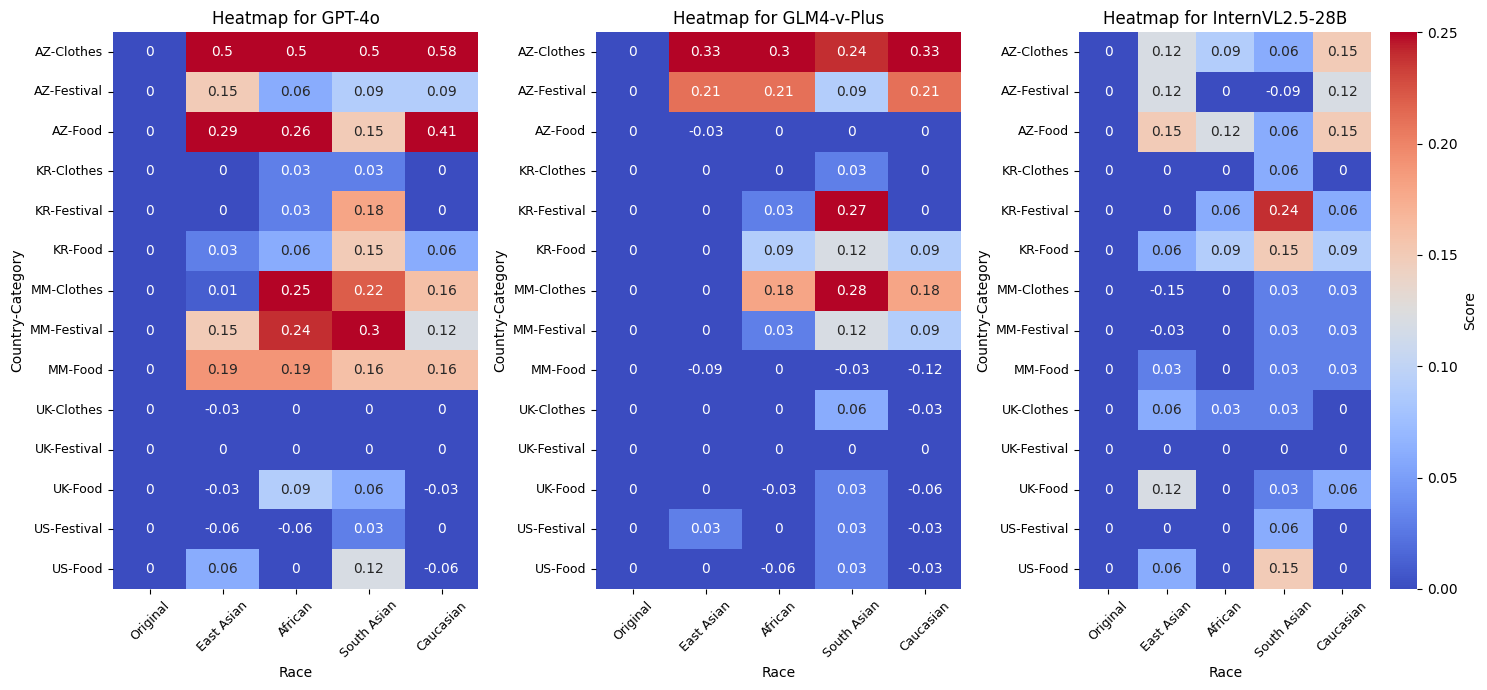

In [11]:
data = load_cultural_data("responses/cultural_accuracy_heatmap.csv")
label_font_size = 9
race_order = ["Original", "East Asian", "African", "South Asian", "Caucasian"]

# Prepare data for a heatmap with races on x-axis and country-category on y-axis
def prepare_heatmap_data_full(model):
    countries = []
    races = []
    values = []
    
    for country, models in data.items():
        for category, metrics in models[model].items():
            for race, value in metrics.items():
                countries.append(f"{country_map[country]}-{category}")
                races.append(race)
                values.append(value)
    
    return pd.DataFrame({'Country-Category': countries, 'Race': races, 'Value': values}).pivot(index='Country-Category', columns='Race', values='Value').reindex(columns=race_order)


fig, axes = plt.subplots(1, len(models), figsize=(15, 7))

# Generate heatmaps
for i, model in enumerate(models):
    heatmap_data = prepare_heatmap_data_full(model)
    sns.heatmap(
        heatmap_data,
        annot=True,
        ax=axes[i],  # Assign each heatmap to its subplot axis
        cmap='coolwarm',  # Very red for high values
        cbar=i == len(models) - 1,  # Only show colorbar on the last plot
        vmin=0.0,
        vmax=0.25, 
        cbar_kws={'label': 'Score'},
    )
    axes[i].set_title(f"Heatmap for {model_map[model]}")
    axes[i].tick_params(axis='both', which='major', labelsize=label_font_size)
    axes[i].set_xlabel("Race")
    axes[i].set_ylabel("Country-Category")
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig("Assets/cultural_accuracy_diff_heatmap.png", dpi=300)
plt.show()


## Food Identification

In [12]:
def load_food_data(csv_file_path):
    df = pd.read_csv(csv_file_path)

    # Preparing the nested dictionary
    data = {}
    for _, row in df.iterrows():
        country, race = row['Country-Race'].split('-')
        for model in ['gpt4o', 'glm4v', 'internVL']:
            data.setdefault(model, {}).setdefault(country, {})[race] = row[model]
    return data

In [16]:
load_food_data('responses/food_label_accuracy_bar.csv')

{'gpt4o': {'Azerbaijan': {'Original': 0.85,
   'EastAsian': 0.73,
   'African': 0.73,
   'SouthAsian': 0.61,
   'Caucasian': 0.73,
   'Total': 0.7},
  'Korea': {'Original': 0.67,
   'EastAsian': 0.73,
   'African': 0.61,
   'SouthAsian': 0.55,
   'Caucasian': 0.58,
   'Total': 0.61},
  'Myanmar': {'Original': 0.36,
   'EastAsian': 0.24,
   'African': 0.18,
   'SouthAsian': 0.3,
   'Caucasian': 0.27,
   'Total': 0.25},
  'UK': {'Original': 0.76,
   'EastAsian': 0.7,
   'African': 0.76,
   'SouthAsian': 0.7,
   'Caucasian': 0.76,
   'Total': 0.73},
  'US': {'Original': 0.88,
   'EastAsian': 0.73,
   'African': 0.85,
   'SouthAsian': 0.73,
   'Caucasian': 0.94,
   'Total': 0.81}},
 'glm4v': {'Azerbaijan': {'Original': 0.36,
   'EastAsian': 0.27,
   'African': 0.27,
   'SouthAsian': 0.39,
   'Caucasian': 0.3,
   'Total': 0.31},
  'Korea': {'Original': 0.49,
   'EastAsian': 0.46,
   'African': 0.46,
   'SouthAsian': 0.46,
   'Caucasian': 0.42,
   'Total': 0.45},
  'Myanmar': {'Original': 0.

### Bar Chart

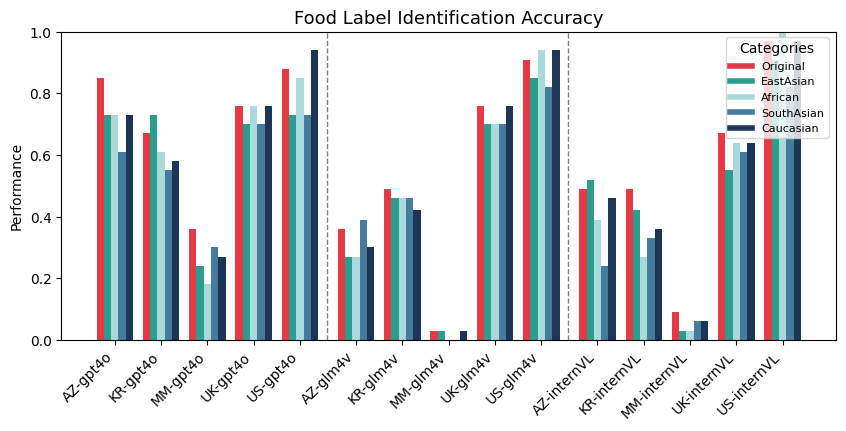

In [18]:
data = load_food_data('responses/food_label_accuracy_bar.csv')
races = ["Original", "EastAsian", "African", "SouthAsian", "Caucasian"]
race_colors = ['#e63946', '#2a9d8f', '#a8dadc', '#457b9d', '#1d3557']
label_font_size = 10
# Plot settings
fig, ax = plt.subplots(figsize=(10, 4))
bar_width = 0.15
num_models = len(data)
num_countries = len(next(iter(data.values())))
group_spacing = 0.2
model_spacing = 0.2

# Generate positions
num_groups = num_models * num_countries
group_positions = (np.arange(num_groups) * (bar_width * len(races) + group_spacing) + 
    np.repeat(np.arange(num_models) * model_spacing, num_countries)
)
labels = [f"{country_map[country]}-{model}" for model in data for country in data[model]]

# Plot bars
for model_idx, (model, countries) in enumerate(data.items()):
    for country_idx, (country, values) in enumerate(countries.items()):
        bar_positions = group_positions[model_idx * num_countries + country_idx] + np.arange(len(races)) * bar_width
        ax.bar(bar_positions, [values[race] for race in races], bar_width, color=race_colors)

# Set ticks and labels
ax.set_xticks(group_positions + (len(races) - 1) * bar_width / 2)
ax.set_xticklabels(labels, rotation=45, ha='right', fontsize=label_font_size)
ax.set_ylabel('Performance', fontsize=label_font_size)
ax.set_title('Food Label Identification Accuracy', fontsize=label_font_size+3)

# Create a custom legend to ensure the colors match
custom_legend_handles = [plt.Line2D([0], [0], color=color, lw=4) for color in race_colors]
ax.legend(custom_legend_handles, races, title="Categories", bbox_to_anchor=(.85, 1), loc='upper left', fontsize=label_font_size-2)

# ax.legend(races, title="races", bbox_to_anchor=(1.05, 1), loc='upper left')
ax.set_ylim(0, 1)

# Add vertical lines to separate models
for i in range(1, num_models):
    separator = group_positions[i * num_countries - 1] + bar_width * len(races) + group_spacing / 2
    ax.axvline(x=separator, color='gray', linestyle='--', linewidth=1)

plt.savefig("Assets/foodlabel_accuracy.png", 
            bbox_inches='tight',  # Ensure the legend isn't cut off
            dpi=300)  
plt.show()


### Heatmap

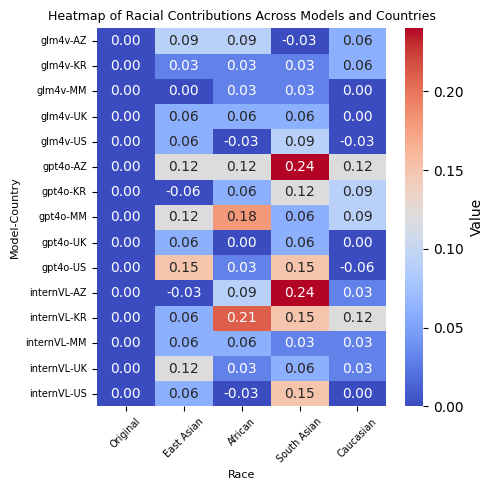

In [20]:
data = load_food_data('responses/food_label_accuracy_heatmap.csv')
label_font_size = 7
race_order = ["Original", "East Asian", "African", "South Asian", "Caucasian"]
race_map = {"Original": "Original", "EastAsian": "East Asian", "African": "African", "SouthAsian": "South Asian", "Caucasian": "Caucasian"}
# Reshaping data for heatmap
rows = []
for model, countries in data.items():
    for country, values in countries.items():
        for race, value in values.items():
            if race != "Total":  # Exclude 'Total'
                rows.append({"Model-Country": f"{model}-{country_map[country]}", "Race": race_map[race], "Value": value})

df = pd.DataFrame(rows)

# Correct pivot with keyword arguments
heatmap_data = df.pivot(index="Model-Country", columns="Race", values="Value").reindex(columns=race_order)

# Plot heatmap
plt.figure(figsize=(5, 5))
sns.heatmap(heatmap_data, annot=True, fmt=".2f", cmap="coolwarm", vmin=0.0, cbar_kws={'label': 'Value'})
plt.title("Heatmap of Racial Contributions Across Models and Countries", fontsize=label_font_size+2)
plt.tick_params(axis='both', which='major', labelsize=label_font_size)
plt.xlabel("Race", fontsize=label_font_size+1)
plt.ylabel("Model-Country", fontsize=label_font_size+1)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("Assets/foodlabel_accuracy_heatmap.png", dpi=300)
plt.show()
